##### test for select_models function
- maybe use the introduction model from figure 1
- 3 models with 2, 5, 15 steps respectively
- create some data with 5-steps model
- is this fast/handy enough for a test?
- run in sequential mode/not parallel

=> test seems to work but is a bit expensive, maybe add later

In [ ]:
import memo_py as me
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
### create data from 5-steps model
t = [
    {'start': 'X_t', 'end': 'X_t', 
     'rate_symbol': 'l', 
     'type': 'S -> S + S', 'reaction_steps': 5}
    ]

net = me.Network('net_div_g5')
net.structure(t)

num_iter = 100
initial_values = {'X_t': 1}
theta_values = {'l': 0.22}
time_values = np.array([0.0, 10.0])
variables = {'X_t': ('X_t', )}

sim = me.Simulation(net)
res_list = list()

for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', initial_values, theta_values, time_values, variables)[1])

sims = np.array(res_list)

In [3]:
data = me.Data('data_test_select_models')
data.load(['X_t',], time_values, sims, bootstrap_samples=10000, basic_sigma=1/num_iter)

# overwrite with known values (from a num_iter=100 simulation)
data.data_mean = np.array([[[1.         , 3.73      ]],
                           [[0.01       , 0.15406761]]])
data.data_variance = np.array([[[0.         , 2.36070707]],
                               [[0.01       , 0.32208202]]])

In [4]:
print(data.data_mean)
print(data.data_variance)
print(data.data_covariance)

[[[1.         3.73      ]]

 [[0.01       0.15406761]]]
[[[0.         2.36070707]]

 [[0.01       0.32208202]]]
[]


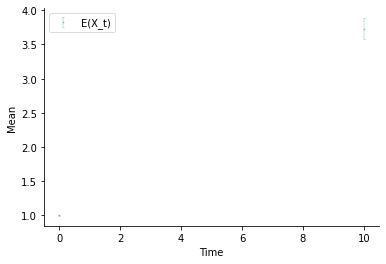

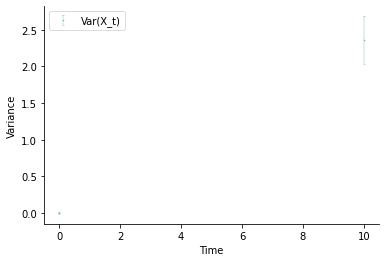

In [5]:
me.plots.data_mean_plot(data)
me.plots.data_variance_plot(data)

In [6]:
t2 = [{'start': 'X_t', 'end': 'X_t', 
     'rate_symbol': 'l', 
     'type': 'S -> S + S', 
     'reaction_steps': 2}]

t5 = [{'start': 'X_t', 'end': 'X_t', 
     'rate_symbol': 'l', 
     'type': 'S -> S + S', 
     'reaction_steps': 5}]

# t10 = [{'start': 'X_t', 'end': 'X_t', 
#      'rate_symbol': 'l', 
#      'type': 'S -> S + S', 
#      'reaction_steps': 10}]

t15 = [{'start': 'X_t', 'end': 'X_t', 
     'rate_symbol': 'l', 
     'type': 'S -> S + S', 
     'reaction_steps': 15}]

# important note: theta_bounds are reduced here to 
# prevent odeint warning at high steps
s = {'initial_values': {'X_t': 1.0}, 
     'theta_bounds': {'l': (0.0, 0.5)}, 
     'variables': {'X_t': ('X_t', )}}

models = [('m2', t2, s), ('m5', t5, s), ('m15', t15, s)]
print(len(models))
print(models)

3
[('m2', [{'start': 'X_t', 'end': 'X_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 2}], {'initial_values': {'X_t': 1.0}, 'theta_bounds': {'l': (0.0, 0.5)}, 'variables': {'X_t': ('X_t',)}}), ('m5', [{'start': 'X_t', 'end': 'X_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 5}], {'initial_values': {'X_t': 1.0}, 'theta_bounds': {'l': (0.0, 0.5)}, 'variables': {'X_t': ('X_t',)}}), ('m15', [{'start': 'X_t', 'end': 'X_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 15}], {'initial_values': {'X_t': 1.0}, 'theta_bounds': {'l': (0.0, 0.5)}, 'variables': {'X_t': ('X_t',)}})]


In [7]:
est_res = me.selection.select_models(models, data, parallel=False) # False (usually here)

In [9]:
for __ in range(10):
    est_res = me.selection.select_models(models, data, parallel=False)
    print([est.bay_est_log_evidence for est in est_res])


[-10.629916697804973, 4.7325886118420755, -5.956029975676918]



[-10.707752281691006, 4.648483811563277, -5.904935097433867]



[-10.660052905403797, 4.786992306046756, -5.865460195018101]



[-10.560456631689906, 4.712198906183986, -6.024845876715448]



[-10.67465188224791, 4.739031922471972, -5.832238436663494]



[-10.688286571898711, 4.796078612214922, -5.866083545090796]



[-10.674939299757629, 4.763798403008956, -5.869504378082593]



[-10.706803542779763, 4.758241853964541, -5.921262356541525]



[-10.55770560556853, 4.770112513127923, -5.9405505492747315]



[-10.660075345658038, 4.832557590020761, -5.869471476946568]


In [10]:
evid_summary = np.array([
    [-10.629916697804973, 4.7325886118420755, -5.956029975676918],
    [-10.707752281691006, 4.648483811563277, -5.904935097433867],
    [-10.660052905403797, 4.786992306046756, -5.865460195018101],
    [-10.560456631689906, 4.712198906183986, -6.024845876715448],
    [-10.67465188224791, 4.739031922471972, -5.832238436663494],
    [-10.688286571898711, 4.796078612214922, -5.866083545090796],
    [-10.674939299757629, 4.763798403008956, -5.869504378082593],
    [-10.706803542779763, 4.758241853964541, -5.921262356541525],
    [-10.55770560556853, 4.770112513127923, -5.9405505492747315],
    [-10.660075345658038, 4.832557590020761, -5.869471476946568]
])
print(evid_summary.shape)
print(np.mean(evid_summary, axis=0))
print(np.std(evid_summary, axis=0)*6)

(10, 3)
[-10.65206408   4.75400845  -5.90503819]
[0.30803495 0.28754652 0.3252738 ]


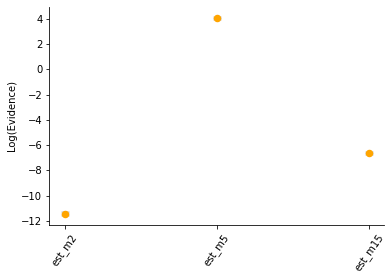

In [18]:
me.plots.selection_plot(est_res)

In [19]:
me.selection.compute_model_probabilities(est_res)

array([1.97803966e-07, 9.99975631e-01, 2.41710544e-05])

In [18]:
print(np.array([est.bay_est_params_conf for est in est_res]))

print(est_res[0].bay_est_log_likelihood_max)
print(est_res[1].bay_est_log_likelihood_max)
print(est_res[2].bay_est_log_likelihood_max)

print(est_res[0].bay_log_likelihood_norm)
print(est_res[1].bay_log_likelihood_norm)
print(est_res[2].bay_log_likelihood_norm)

[[[0.15403995 0.14659241 0.16079126]]

 [[0.21181266 0.20239213 0.22030757]]

 [[0.23227569 0.21840278 0.24577387]]]
-6.655917426977538
8.536409735755383
-2.583752295846338
8.537899031472271
8.537899031472271
8.537899031472271


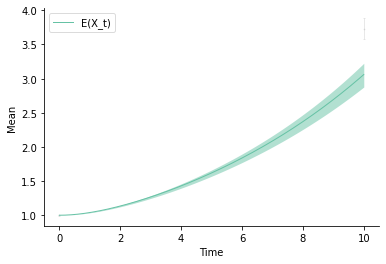

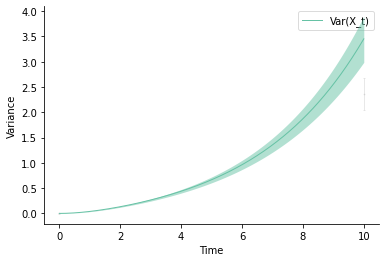

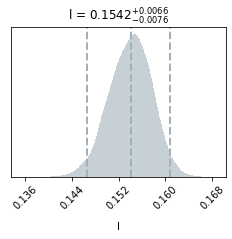

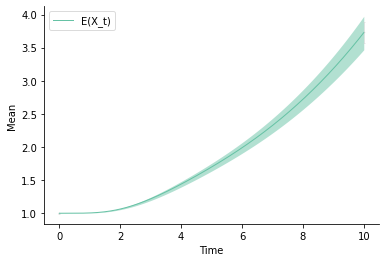

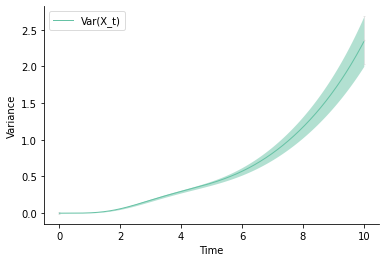

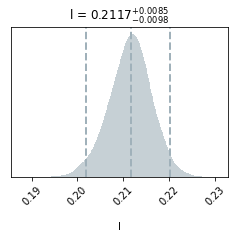

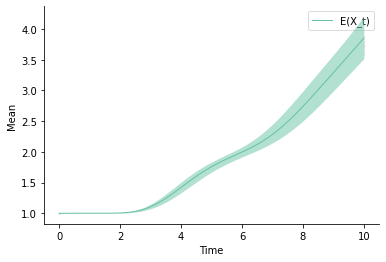

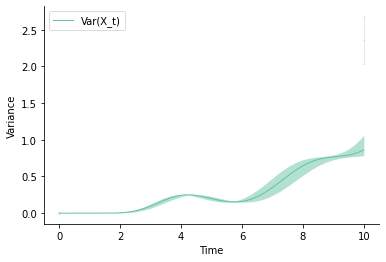

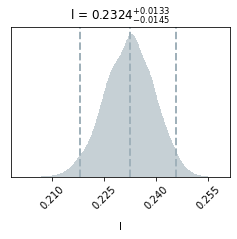

In [20]:
me.plots.est_bestfit_mean_plot(est_res[0])
me.plots.est_bestfit_variance_plot(est_res[0])
me.plots.est_corner_kernel_plot(est_res[0])

me.plots.est_bestfit_mean_plot(est_res[1])
me.plots.est_bestfit_variance_plot(est_res[1])
me.plots.est_corner_kernel_plot(est_res[1])

me.plots.est_bestfit_mean_plot(est_res[2])
me.plots.est_bestfit_variance_plot(est_res[2])
me.plots.est_corner_kernel_plot(est_res[2])

##### check warning
/Users/mlanghinrichs/opt/anaconda3/envs/cd44_project/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
  
=> bug found: this warning occured when l values were too high *and* at the same time very few time values were used in the odeint (2 in the estimation)

In [7]:
models_check = [('m15', t15, s)]
est_check = me.selection.select_models(models_check, data)

/Users/mlanghinrichs/opt/anaconda3/envs/cd44_project/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [ ]:
est = est_check[0]
np.mean(est.bay_est_samples_weighted)
# 0.23235173968206016

In [70]:
t = [{'start': 'X_t', 'end': 'X_t', 
     'rate_symbol': 'l', 
     'type': 'S -> S + S', 
     'reaction_steps': 15}]

net = me.Network('net_check')
net.structure(t)

network_setup = {
    'initial_values': {'X_t': 1.0}, 
    'theta_bounds': {'l': (0.0, 1.0)}, 
    'mean_only': False,
    'variables': {'X_t': ('X_t', )}
}

mcmc_setup = {
    'nlive':                    1000, # 250 # 1000
    'tolerance':                0.01, # 0.1 (COARSE) # 0.05 # 0.01 (NORMAL)
    'bound':                    'multi',
    'sample':                   'unif'
}

est = me.Estimation('est_check', net, data)
est.estimate(network_setup, mcmc_setup)

/Users/mlanghinrichs/opt/anaconda3/envs/cd44_project/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [71]:
np.mean(est.bay_est_samples_weighted)

0.2322282859721292

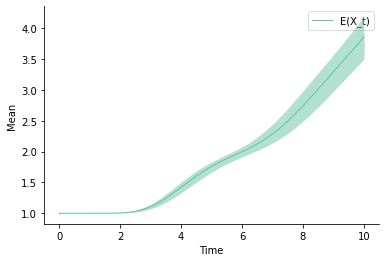

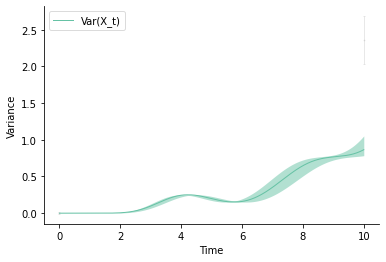

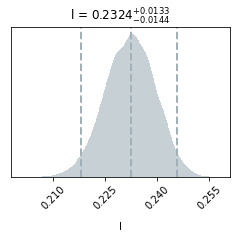

In [72]:
me.plots.est_bestfit_mean_plot(est)
me.plots.est_bestfit_variance_plot(est)
me.plots.est_corner_kernel_plot(est)

/Users/mlanghinrichs/opt/anaconda3/envs/cd44_project/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


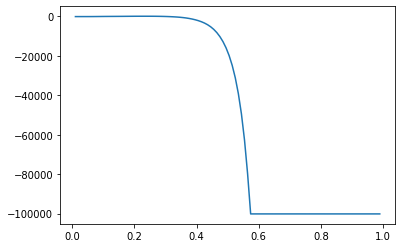

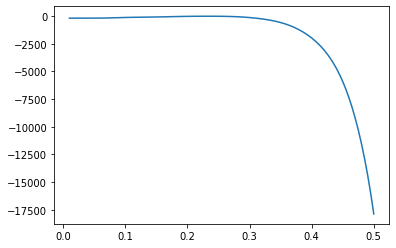

In [75]:
# check some likelihoods manually
initial_values = {'X_t': 1}
theta_values = {'l': 0.22}
time_values = np.array([0.0, 10.0])
variables = {'X_t': ('X_t', )}

# warning
plt.figure()
x_vals = np.linspace(0.01, 0.99, num=100, endpoint=True)
plt.plot(x_vals, np.array([est.log_likelihood(np.array([x]), 
                initial_values, time_values, variables, 
               data.data_mean, data.data_variance, 
                data.data_covariance) for x in x_vals]))

# no warning
plt.figure()
x_vals = np.linspace(0.01, 0.5, num=100, endpoint=True)
plt.plot(x_vals, np.array([est.log_likelihood(np.array([x]), 
                initial_values, time_values, variables, 
               data.data_mean, data.data_variance, 
                data.data_covariance) for x in x_vals]))

/Users/mlanghinrichs/opt/anaconda3/envs/cd44_project/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


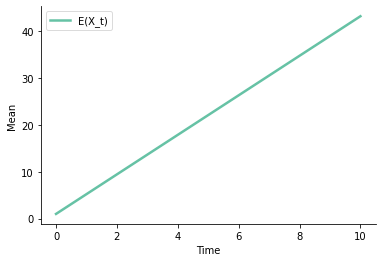

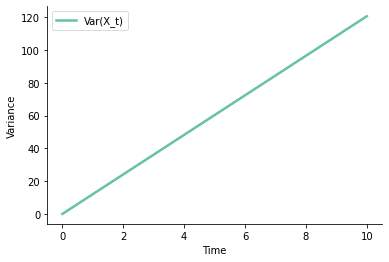

[{'module': 'module_0', 'start-end': ('X_t', 'X_t'), 'start-end_ident': ('Z_0', 'Z_0'), 'sym_rate': 'l', 'sym_rate_ident': 'theta_0', 'type': 'S -> S + S', 'module_steps': 15}]


In [69]:
net = me.Network('net_check')
net.structure(t15)

initial_values = {'X_t': 1}
theta_values = {'l': 0.9}
time_values = np.linspace(0.0, 10.0, num=2, endpoint=True)
variables = {'X_t': ('X_t', )}

sim = me.Simulation(net)

sim.simulate('moments', initial_values, theta_values, 
             time_values, variables, estimation_mode=False)

me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)

print(net.net_modules)

In [13]:
print(sim.sim_moments.theta_numeric)
type(sim.sim_moments.theta_numeric)

[0.26]


numpy.ndarray

In [34]:
from scipy.integrate import odeint
from numba import jit
str_for_exec = sim.sim_moments.moment_eqs_template_str

exec(str_for_exec)
_moment_eqs_template = eval('_moment_eqs_template')

moment_system = _moment_eqs_template # sim.sim_moments.moment_system
init = sim.sim_moments.moment_initial_values
time_arr = time_values
theta = np.random.rand(1) # np.array([theta_values['l']])
sol = odeint(moment_system, init, time_arr, args=(theta, ))
sol

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.02165184e-01, 3.45904512e-01, 1.19134040e-01, ...,
        3.75346400e-40, 7.15974825e-42, 1.28299004e-43],
       [2.52169869e-01, 3.47402412e-01, 2.39299858e-01, ...,
        3.03577300e-29, 2.02680435e-30, 1.35626766e-31],
       ...,
       [4.08418084e+01, 3.89975873e+01, 3.72366027e+01, ...,
        7.71629928e+02, 7.36628868e+02, 7.03336644e+02],
       [4.21941266e+01, 4.02888489e+01, 3.84695795e+01, ...,
        8.23618955e+02, 7.86264703e+02, 7.50729816e+02],
       [4.35912346e+01, 4.16228650e+01, 3.97433693e+01, ...,
        8.79109129e+02, 8.39243651e+02, 8.01315330e+02]])

CPUDispatcher(<function _moment_eqs_template at 0x7fd645d1e5f0>)

In [16]:
print(str_for_exec)

def _moment_eqs_template(m, time, theta):
	return np.array([
	-15.0*m[0]*theta[0] + 30.0*m[6]*theta[0],
	15.0*m[0]*theta[0] - 15.0*m[1]*theta[0],
	15.0*m[1]*theta[0] - 15.0*m[2]*theta[0],
	15.0*m[14]*theta[0] - 15.0*m[3]*theta[0],
	15.0*m[3]*theta[0] - 15.0*m[4]*theta[0],
	15.0*m[4]*theta[0] - 15.0*m[5]*theta[0],
	15.0*m[5]*theta[0] - 15.0*m[6]*theta[0],
	15.0*m[2]*theta[0] - 15.0*m[7]*theta[0],
	15.0*m[7]*theta[0] - 15.0*m[8]*theta[0],
	15.0*m[8]*theta[0] - 15.0*m[9]*theta[0],
	-15.0*m[10]*theta[0] + 15.0*m[9]*theta[0],
	15.0*m[10]*theta[0] - 15.0*m[11]*theta[0],
	15.0*m[11]*theta[0] - 15.0*m[12]*theta[0],
	15.0*m[12]*theta[0] - 15.0*m[13]*theta[0],
	15.0*m[13]*theta[0] - 15.0*m[14]*theta[0],
	-30.0*m[15]*theta[0] + 60.0*m[21]*theta[0] + 30.0*m[6]*theta[0],
	15.0*m[15]*theta[0] - 30.0*m[16]*theta[0] + 30.0*m[35]*theta[0],
	15.0*m[16]*theta[0] - 30.0*m[17]*theta[0] + 30.0*m[48]*theta[0],
	-30.0*m[18]*theta[0] + 15.0*m[29]*theta[0] + 30.0*m[60]*theta[0],
	15.0*m[18]*theta[0] - 30.0*m[19

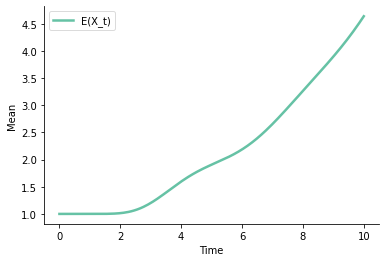

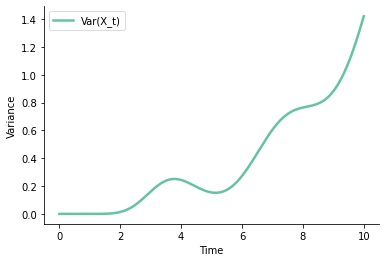

[{'module': 'module_0', 'start-end': ('X_t', 'X_t'), 'start-end_ident': ('Z_0', 'Z_0'), 'sym_rate': 'l', 'sym_rate_ident': 'theta_0', 'type': 'S -> S + S', 'module_steps': 15}]


In [17]:
sim = me.Simulation(net)

sim.simulate('moments', initial_values, theta_values, 
             time_values, variables, estimation_mode=True)

me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)

print(net.net_modules)

In [13]:
print(sim.sim_moments.moment_eqs_template_str)

@jit(nopython=True)
def _moment_eqs_template(m, time, theta):
	return np.array([
	-15.0*m[0]*theta[0] + 30.0*m[6]*theta[0],
	15.0*m[0]*theta[0] - 15.0*m[1]*theta[0],
	15.0*m[1]*theta[0] - 15.0*m[2]*theta[0],
	15.0*m[14]*theta[0] - 15.0*m[3]*theta[0],
	15.0*m[3]*theta[0] - 15.0*m[4]*theta[0],
	15.0*m[4]*theta[0] - 15.0*m[5]*theta[0],
	15.0*m[5]*theta[0] - 15.0*m[6]*theta[0],
	15.0*m[2]*theta[0] - 15.0*m[7]*theta[0],
	15.0*m[7]*theta[0] - 15.0*m[8]*theta[0],
	15.0*m[8]*theta[0] - 15.0*m[9]*theta[0],
	-15.0*m[10]*theta[0] + 15.0*m[9]*theta[0],
	15.0*m[10]*theta[0] - 15.0*m[11]*theta[0],
	15.0*m[11]*theta[0] - 15.0*m[12]*theta[0],
	15.0*m[12]*theta[0] - 15.0*m[13]*theta[0],
	15.0*m[13]*theta[0] - 15.0*m[14]*theta[0],
	-30.0*m[15]*theta[0] + 60.0*m[21]*theta[0] + 30.0*m[6]*theta[0],
	15.0*m[15]*theta[0] - 30.0*m[16]*theta[0] + 30.0*m[35]*theta[0],
	15.0*m[16]*theta[0] - 30.0*m[17]*theta[0] + 30.0*m[48]*theta[0],
	-30.0*m[18]*theta[0] + 15.0*m[29]*theta[0] + 30.0*m[60]*theta[0],
	15.0*m[18]*

##### simple estimation example for testing

In [28]:
# do a minimal model with steps=2 activation and steps=4 division
# three time points maybe

t = [
    {'start': 'X_t', 'end': 'Y_t', 
     'rate_symbol': 'd', 
     'type': 'S -> E', 'reaction_steps': 2},
    {'start': 'Y_t', 'end': 'Y_t', 
     'rate_symbol': 'l', 
     'type': 'S -> S + S', 'reaction_steps': 4}
    ]

net = me.Network('net_min_2_4')
net.structure(t)

num_iter = 100
initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'d': 0.03, 'l': 0.07}
time_values = np.array([0.0, 20.0, 40.0])
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

sim = me.Simulation(net)
res_list = list()

for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', initial_values, theta_values, time_values, variables)[1])

sims = np.array(res_list)

In [29]:
data = me.Data('data_test_est_min_2_4')
data.load(['X_t', 'Y_t'], time_values, sims, 
          bootstrap_samples=10000, basic_sigma=1/num_iter)

# overwrite with fixed values (from a num_iter = 100 simulation)
data.data_mean = np.array([[[1.         ,0.67       ,0.37      ],
                          [0.         ,0.45       ,1.74      ]],
                         [[0.01       ,0.0469473  ,0.04838822],
                          [0.01       ,0.07188642 ,0.1995514 ]]])
data.data_variance = np.array([[[0.         ,0.22333333 ,0.23545455],
                              [0.         ,0.51262626 ,4.03272727]],
                             [[0.01       ,0.01631605 ,0.01293869],
                              [0.01       ,0.08878719 ,0.68612036]]])
data.data_covariance = np.array([[[ 0.         ,-0.30454545 ,-0.65030303]],
                             [[ 0.01        ,0.0303608   ,0.06645246]]])

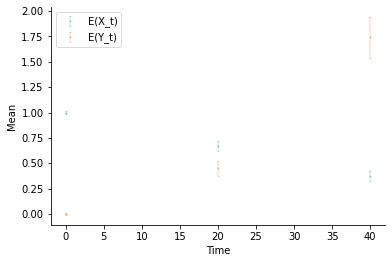

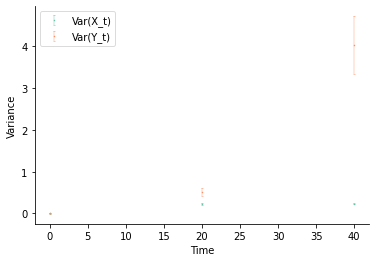

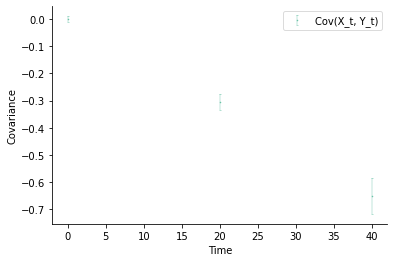

In [34]:
me.plots.data_mean_plot(data)
me.plots.data_variance_plot(data)
me.plots.data_covariance_plot(data)

In [37]:
network_setup = {
    'initial_values': {'X_t': 1, 'Y_t': 0},
    'theta_bounds': {'d': (0.0, 0.15), 'l': (0.0, 0.15)}, 
    'mean_only': False,
    'variables': {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}
}

mcmc_setup = {
    'nlive':                    1000, # 250 # 1000
    'tolerance':                0.01, # 0.1 (COARSE) # 0.05 # 0.01 (NORMAL)
    'bound':                    'multi',
    'sample':                   'unif'
}

est = me.Estimation('est_min_2_4', net, data)
est.estimate(network_setup, mcmc_setup)

In [47]:
print(est.bay_est_log_evidence)
# 28.298372548269864, 28.139812540432732

print(est.bay_est_log_likelihood_max)
# 35.48531419345989

print(np.array([est.bay_est_params_conf]))

28.139812540432732
35.48531419345989
[[[0.02803474 0.02594989 0.03014408]
  [0.07470537 0.06919784 0.07955645]]]


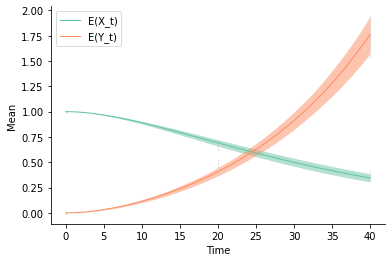

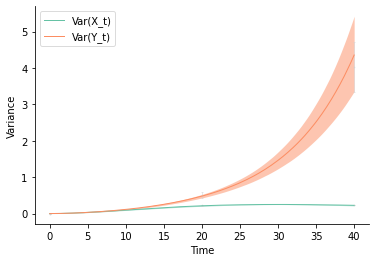

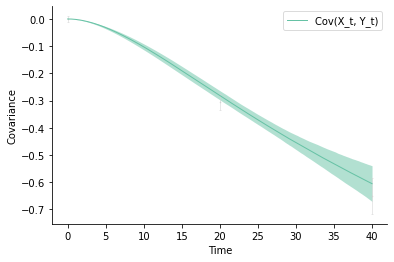

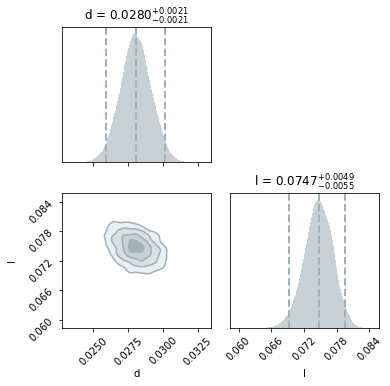

In [40]:
me.plots.est_bestfit_mean_plot(est)
me.plots.est_bestfit_variance_plot(est)
me.plots.est_bestfit_covariance_plot(est)
me.plots.est_corner_kernel_plot(est) # d=0.028, l=0.075

In [43]:
print(type(est.bay_nested_sampler))
type(est.bay_nested_sampler_res)

<class 'dynesty.nestedsamplers.MultiEllipsoidSampler'>


dynesty.results.Results

In [49]:
# est is a memopy estimation instance
est.get_model_evidence(est.bay_nested_sampler_res)

(28.139812540432732, 0.11225503808864087)

In [50]:
est.bay_est_log_evidence


28.139812540432732

In [51]:
est.bay_est_log_evidence_error

0.11225503808864087